In [1]:
import csv
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import json
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import pickle
from joblib import dump
import networkx as nx
import random
import pandas as pd


nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#frequent mitre words
freq_mitre_words = ['domain', 'api', 'web', 'password', 'script', 'program', 'registry', 'exe', 'traffic', 'key', 'protocol', 'device', 'log', 'cloud', 'gather', 'persistence', 'malware', 'binary', 'directory', 'security', 'search', 'authentication', 'privilege', 'compromise', 'email', 'infrastructure', 'utility', 'legitimate', 'host', 'certificate', 'permission', 'modify', 'discovery', 'argument', 'time', 'organization', 'perform', 'powershell', 'operating', 'connection', 'abuse', 'call', 'function', 'compromised', 'content', 'executed', 'image', 'local', 'set', 'name']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ktouloumis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
#function most frequent words from corpus
def get_top_n_words(corpus, n=None):
    # receives a list of sentences
    # the most frequent words with their number of appearances
    vec = CountVectorizer(max_df=0.2).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [3]:
#function to preprocess description
def preprocessDesc(desc):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~\\'''
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(desc)
    
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if
                         w.lower() not in en_stop and w.lower() not in freq_mitre_words and w not in punc]
    res = [x for x in filtered_sentence if not any(map(str.isdigit, x)) and '\\' not in x and '/' not in x and '-' not in x and x not in freq_mitre_words]
    return res

In [4]:
# function for printing cluster centroids
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # print("\nTopic #%d:" % topic_idx)
        topici = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics[topic_idx] = topici

    with open('lda-topics.txt', 'w') as outfile:
        json.dump(topics, outfile)

In [5]:
#preprocess every mitre entry for clustering
df = pd.read_excel('enterprise-attack-v9.0-techniques.xlsx') #,index_col=0

dfids = df['ID'].tolist()
dfdetect = df['detection'].tolist()
dfname = df['name'].tolist()
dfdesc = df['description'].tolist()

stem_ls=[]

for name, desc, det in zip(dfname, dfdesc, dfdetect):
    toks = preprocessDesc(name+desc+det)
    fullstring = ' '.join(toks)
    stem_ls.append(fullstring)


In [6]:
#get most common words
ls_common_words = []
common_words = get_top_n_words(stem_ls, 50)
for word, freq in common_words:
    print(word, freq)
    ls_common_words.append(word)
print(ls_common_words)

exe 211
open 127
memory 127
management 126
task 125
communication 125
method 124
initial 124
feature 123
new 122
address 122
dll 121
create 121
order 120
part 120
running 119
mechanism 117
configuration 116
directly 116
injection 115
various 115
typically 114
run 113
phishing 112
modification 110
type 108
analyze 108
location 108
outside 107
look 106
potentially 106
capability 106
boot 106
source 105
token 105
bypass 104
effort 104
path 104
take 103
one 103
instance 102
place 102
depending 102
medium 102
targeting 101
value 101
payload 100
form 100
component 99
existing 99
['exe', 'open', 'memory', 'management', 'task', 'communication', 'method', 'initial', 'feature', 'new', 'address', 'dll', 'create', 'order', 'part', 'running', 'mechanism', 'configuration', 'directly', 'injection', 'various', 'typically', 'run', 'phishing', 'modification', 'type', 'analyze', 'location', 'outside', 'look', 'potentially', 'capability', 'boot', 'source', 'token', 'bypass', 'effort', 'path', 'take', 'one

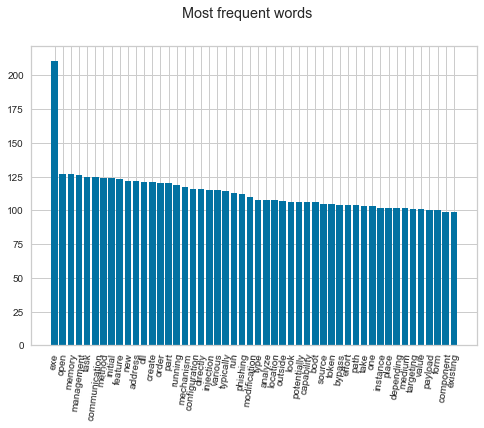

In [7]:
#show most frequent words
import matplotlib.pyplot as plt

words = [i[0] for i in common_words]
appears = [i[1] for i in common_words]
plt.bar(words, appears)
plt.suptitle('Most frequent words')
plt.xticks(rotation='82.5')

#plt.savefig('freq_words.png', dpi=400)
plt.show()

In [8]:
# initialize tf-idf vectorizer and and transform text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.15)
X = vectorizer.fit_transform(stem_ls)
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

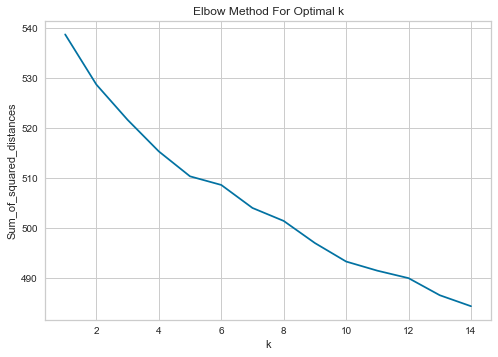

In [9]:
#Find best k from elbow methods
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
# train model 
n = 10
model = KMeans(n_clusters=n, init='k-means++', max_iter=100, n_init=1)
model.fit_predict(X)

array([0, 0, 6, 0, 0, 7, 7, 7, 6, 7, 7, 6, 4, 4, 4, 1, 4, 0, 1, 4, 1, 8,
       6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 2, 2, 2, 2, 2, 4, 6, 6, 6, 6, 6, 4,
       6, 2, 6, 6, 6, 9, 6, 9, 0, 6, 6, 0, 8, 9, 6, 6, 6, 6, 5, 5, 5, 5,
       8, 8, 4, 6, 1, 1, 9, 1, 1, 5, 6, 4, 6, 4, 8, 8, 8, 8, 6, 8, 8, 8,
       8, 0, 3, 3, 3, 2, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 5, 5, 5,
       6, 4, 6, 6, 0, 6, 0, 6, 0, 2, 2, 2, 6, 6, 6, 6, 6, 2, 2, 2, 2, 4,
       4, 4, 2, 6, 6, 6, 6, 6, 6, 6, 4, 4, 0, 6, 6, 6, 6, 5, 6, 7, 6, 6,
       6, 0, 0, 0, 0, 7, 7, 6, 4, 6, 6, 1, 6, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 1, 5, 3, 3, 3, 6, 6, 6, 6, 6, 6, 0, 5, 6, 6, 6, 0, 6, 8,
       8, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 5, 6, 9, 6, 6, 6,
       5, 2, 4, 8, 8, 6, 0, 6, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 0, 0, 0, 0, 0, 0, 4, 6, 6, 6, 6,
       6, 0, 6, 6, 0, 0, 0, 6, 4, 6, 6, 6, 6, 6, 6, 0, 6, 5, 6, 6, 6, 6,
       6, 0, 0, 6, 2, 6, 6, 6, 8, 6, 6, 6, 0, 1, 6,

In [11]:
#Save models
filename = 'kmeans_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [12]:
#Get centroids
centroids = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n):
    l = []
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        l.append(terms[ind])
    centroids['cluster ' + str(i)] = l
    
with open('kmeans-centroids.txt', 'w') as outfile:
    json.dump(centroids, outfile)

Cluster 0:
 removable
 disk
 com
 firmware
 hidden
 path
 boot
 medium
 object
 drive
 keychain
 plist
 component
 hide
 attribute
Cluster 1:
 office
 outlook
 attack
 address
 rule
 exchange
 failure
 endpoint
 availability
 denial
 ip
 cause
 sensepost
 message
 sudden
Cluster 2:
 communication
 analyze
 packet
 client
 port
 channel
 sending
 uncommon
 significantly
 receives
 birmingham
 university
 seen
 utilizing
 expected
Cluster 3:
 initial
 phishing
 open
 reconnaissance
 reveal
 social
 opportunity
 operational
 occurrence
 establishing
 lifecycle
 rate
 stage
 visibility
 taking
Cluster 4:
 management
 instance
 interact
 group
 learns
 net
 taken
 instrumentation
 isolation
 acquired
 viewed
 based
 obtained
 occur
 lead
Cluster 5:
 container
 logon
 docker
 kubernetes
 daemon
 launch
 agent
 deployment
 initialization
 cluster
 deploy
 containerized
 launchctl
 abnormal
 emond
Cluster 6:
 injection
 exploitation
 exe
 exploit
 dll
 spearphishing
 link
 dlls
 signature
 cap

In [13]:
#Load models
model = pickle.load(open('kmeans_model.sav', 'rb'))
vectorizer = pickle.load(open('vectorizer.pickle', "rb"))



In [14]:
#Get all Mitre entries and cluster them 
ids = []
for i in range(0, n):
    ids.append([])

for i, name, desc, det in zip(dfids, dfname, dfdesc, dfdetect):
    toks = preprocessDesc(name+desc+det)
    fullstring = ' '.join(toks)
   
    Y = vectorizer.transform([fullstring])
    prediction = model.predict(Y)
    ids[prediction[0]].append(i)

In [15]:
#Show mitre ids per cluster
for n, i in enumerate(ids):
    print("Cluster "+str(n)+ ' has ids:', i)
    

Cluster 0 has ids: ['T1548', 'T1548.002', 'T1548.001', 'T1548.003', 'T1098', 'T1547.011', 'T1547.007', 'T1092', 'T1555.001', 'T1555.002', 'T1485', 'T1025', 'T1006', 'T1561', 'T1561.001', 'T1561.002', 'T1546.015', 'T1546.013', 'T1052', 'T1052.001', 'T1495', 'T1564', 'T1564.005', 'T1564.001', 'T1564.002', 'T1564.003', 'T1564.004', 'T1574.004', 'T1574.007', 'T1574.008', 'T1574.009', 'T1562.003', 'T1070.005', 'T1070.006', 'T1559.001', 'T1036.003', 'T1556.004', 'T1556.003', 'T1542', 'T1542.003', 'T1542.002', 'T1542.004', 'T1542.001', 'T1021.003', 'T1091', 'T1014', 'T1113', 'T1218.003', 'T1218.004', 'T1218.009', 'T1218.010', 'T1553', 'T1553.006', 'T1553.001', 'T1195', 'T1195.003', 'T1195.001', 'T1195.002', 'T1529', 'T1080']
Cluster 1 has ids: ['T1087.003', 'T1098.003', 'T1098.002', 'T1110', 'T1110.004', 'T1110.001', 'T1110.003', 'T1568.003', 'T1568.001', 'T1114', 'T1114.003', 'T1114.001', 'T1114.002', 'T1499', 'T1499.003', 'T1499.004', 'T1499.001', 'T1499.002', 'T1559.002', 'T1557.002', 'T15